# Stanley Control

In [1]:
SIM_TIME_DT = 0.5

In [2]:
import numpy as np

class Model():

    MODEL_L_M = 3
    MODEL_STEER_MIN = -np.radians(50.0)
    MODEL_STEER_MAX = np.radians(50.0)
    

    def __init__(self, x=0.0, y=0.0, theta=0.0, v=0.0):
        self.x = x
        self.y = y
        self.theta = theta
        self.v = v
        self.steer = 0

        self.plt_rear = None
        self.plt_body = None
        self.plt_front = None

    def control(self, v, steer):
        self.x += self.v * np.cos(self.theta) * SIM_TIME_DT
        self.y += self.v * np.sin(self.theta) * SIM_TIME_DT
        self.theta += self.v / Model.MODEL_L_M * np.tan(self.steer) * SIM_TIME_DT

        self.v = v
        self.steer = np.clip(steer, Model.MODEL_STEER_MIN, Model.MODEL_STEER_MAX)
    
    def get_state(self):
        return (self.x, self.y, self.theta, self.steer)
    
    def plot(self, ax):
        # if self.plt_rear:
        #     self.plt_rear.remove()
        self.plt_rear = ax.plot(self.x, self.y, "r", marker=".", markersize=2)[0]

        if self.plt_body:
            self.plt_body.remove()
        self.plt_body = ax.arrow(self.x, self.y, Model.MODEL_L_M*np.cos(self.theta), Model.MODEL_L_M*np.sin(self.theta), color='g')

        if self.plt_front:
            self.plt_front.remove()
        front = (self.x + Model.MODEL_L_M*np.cos(self.theta), self.y + Model.MODEL_L_M*np.sin(self.theta), np.pi/2 + self.theta + self.steer)
        self.plt_front = ax.arrow(front[0]-np.cos(front[2]), front[1]-np.sin(front[2]), 2*np.cos(front[2]), 2*np.sin(front[2]), color='b')


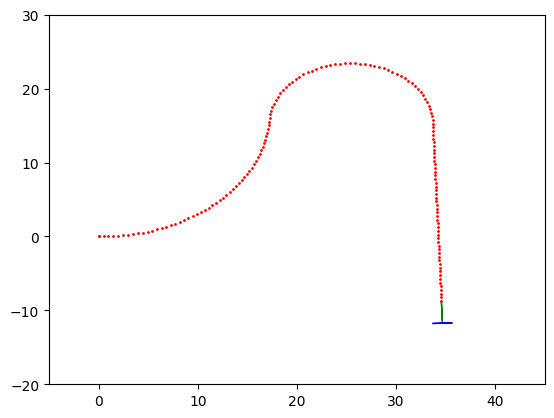

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation

fig, ax = plt.subplots()
ax.axis([-5, 45, -20, 30])
ax.plot([],[])

model = Model(0, 0, 0, 0)
controls  = []
controls += [(1, np.radians(10.0))  for i in range(50)]
controls += [(1, np.radians(-20.0)) for i in range(50)]
controls += [(1, np.radians(0)) for i in range(50)]

targets = []

def target_loop(i):

    model.plot(ax)

    v, steer = controls[i]
    model.control(v=v, steer=steer)

    x, y, _, _ = model.get_state()
    targets.append((x,y))

ani = matplotlib.animation.FuncAnimation(fig, target_loop, frames=len(controls))
from IPython.display import HTML
HTML(ani.to_jshtml())

In [4]:
class Stanley():

    def __init__(self, targets, param_k) -> None:
        self.targets = targets
        self.PARAM_K = param_k

    def get_nearest(self, x, y, theta, lm):
        x += lm*np.cos(theta)
        y += lm*np.sin(theta)
        for idx, target in enumerate(self.targets):
            dist = np.sqrt((x-target[0])**2 + (y-target[1])**2)
            if idx == 0:
                min_dist = dist
                min_targ = target
                min_targ_prev = (0,0)
                min_targ_next = self.targets[idx+1]
            elif min_dist > dist:
                min_dist = dist
                min_targ = target
                if idx == 0:
                    min_targ_prev = (0,0)
                else:
                    min_targ_prev = self.targets[idx-1]
                if idx == len(self.targets) - 1:
                    min_targ_next = (0,0)
                else:
                    min_targ_next = self.targets[idx+1]

        tangent = np.arctan2(min_targ_next[1] - min_targ_prev[1], min_targ_next[0] - min_targ_prev[0])

        # tangent equation
        # mx + ny + p = 0
        # y = tan(alpha)*(x - a) + b
        # tan(alpha)x - y + (b-a*tan(alpha)) = 0
        sign = np.tan(tangent) * x - y + (min_targ[1] - min_targ[0]*np.tan(tangent))
        sign = sign/abs(sign)
        return (sign * min_dist, min_targ, tangent)

    def get_steer(self, x, y, theta, v, lm):

        e_fa, target, tangent = self.get_nearest(x, y, theta, lm)
        # print((e_fa, target, tangent))

        err_heading = tangent - theta
        # print(err_heading)

        err_cross = 0
        # print((Stanley.PARAM_K * self.v, e_fa))
        err_cross = np.arctan(e_fa / self.PARAM_K * v)

        # print(err_cross)

        steer = err_heading + err_cross
        return (steer, target, tangent)

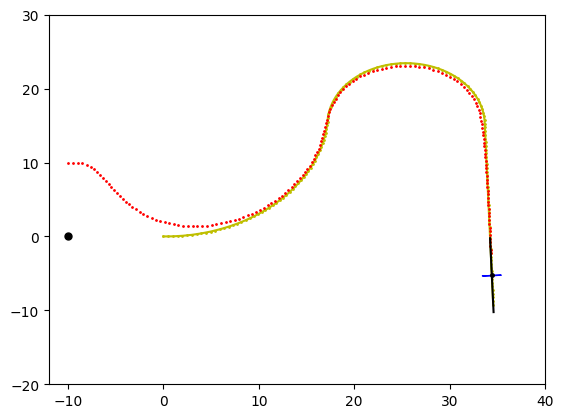

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation

fig, ax = plt.subplots()
ax.axis([-12, 40, -20, 30])
ax.plot([p[0] for p in targets], [p[1] for p in targets], "y", marker=".", markersize=2)
ax.plot(-10, 0, "black", marker=".", markersize=10)

model = Model(-10, 10, 0, 1)
controller = Stanley(targets, 5)

point = None
front = None
def plot_target(ax, target, tangent):
    global point, front
    if point:
        point.remove()
    point = ax.plot(target[0], target[1], "black", marker=".", markersize=5)[0]

    if front:
        front.remove()
    size = 5
    start = (target[0] - size*np.cos(tangent), target[0] + size*np.cos(tangent))
    end   = (target[1] - size*np.sin(tangent), target[1] + size*np.sin(tangent))
    front = ax.plot(start, end, color='black')[0]

def control_loop(i):
    model.plot(ax)
    
    steer, target, tangent = controller.get_steer(model.x, model.y, model.theta, model.v, model.MODEL_L_M)
    plot_target(ax, target, tangent)

    model.control(v=model.v, steer=steer)
    return False


# ani = matplotlib.animation.FuncAnimation(fig, control_loop, frames=1)
ani = matplotlib.animation.FuncAnimation(fig, control_loop, frames=len(controls) + 10)
from IPython.display import HTML
HTML(ani.to_jshtml())